In [1]:
%matplotlib inline

# Imports

In [2]:
import glob
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi


###The following is used to create some sensible results folders according to the year/month
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Custom plotting parameters

In [3]:
import matplotlib
###Default for jupyter display
matplotlib.rcParams['figure.dpi']= 150

matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['legend.fontsize'] = 10
# matplotlib.rcParams['text.usetex'] = True

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Load in the combined `.tsv` file and some notebook-wide variables


In [4]:
combined_df = pd.read_csv('../Data/MVP_data/562_associated_data/ecoli.combined.tsv', sep='\t', index_col=0)
combined_df['SD_accessibility'] = combined_df['sec_struct'] - combined_df['sec_struct_bound']
combined_df.head()

,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,...,GC_upstream,locus_tag,Gene,prot_abundance,trans_eff_2014,trans_eff_2019,essentiality_ds1,essentiality_ds2,essentiality,SD_accessibility
0,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,...,0.433333,b0002,thrA,317.0,0.98,NaN,Non-essential,Non-essential,Non-essential,-8.50
1,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,...,0.500000,b0003,thrB,76.3,0.63,NaN,Non-essential,Non-essential,Non-essential,-7.82
2,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,...,0.566667,b0004,thrC,530.0,1.40,NaN,Non-essential,Non-essential,Non-essential,-3.73
3,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,...,0.400000,b0005,yaaX,NaN,0.28,NaN,Non-essential,Non-essential,Non-essential,-9.77
4,NC_000913.3,RefSeq,CDS,5683,6459,.,-,0,ID=cds-NP_414547.1;Parent=gene-b0006;Dbxref=Un...,ATGCTGATTCTTATTTCACCTGCGAAAACGCTTGATTACCAAAGCC...,...,0.466667,b0006,yaaA,47.9,2.07,0.410931,Non-essential,Non-essential,Non-essential,-10.08


In [5]:
###For prettier plotting
col_to_label_dict = {'aSD_binding': 'aSD binding energy (kcal/mol)',
                    'SD_accessibility': 'SD accessibility (kcal/mol)',
                    'prot_abundance': 'Protein abundance',
                    'iCUB': 'iCUB',
                    'GC_upstream': 'Upstream GC content',
                    'GC_cds': 'Coding sequence GC content',
                    'sec_struct': 'Start codon secondary\nstructure (kcal/mol)',
                    'sec_struct_bound': 'Ribosome bound\nstart codon secondary\nstructure (kcal/mol)',
                    'trans_eff_2014': 'Translational efficiency',\
                    'trans_eff_2019': 'Translational efficiency'}

mean_col_to_label_dict = {}
for key, val in col_to_label_dict.items():
    if val[0]==val[0].upper():
        mean_col_to_label_dict[key] = 'Mean ' + val[0].lower() + val[1:]
    else:
        mean_col_to_label_dict[key] = 'Mean ' + val


## Example comparison between host and phage

**Note that T7 id in this database is: 7841 and I'm using the predicted annotations here**

In [8]:
# virus_df = pd.read_csv('../Data/MVP_data/host_linked_genomes/562_rep_viruses/7841.clean.tsv',\
#                        sep='\t', index_col=0)
virus_df = pd.read_csv('../Data/benchmark_viruses/T7.clean.tsv',\
                       sep='\t', index_col=0)
virus_df['SD_accessibility'] = virus_df['sec_struct'] - virus_df['sec_struct_bound']
print(virus_df.shape)
virus_df.head()

(57, 19)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,aSD_binding,sec_struct,sec_struct_bound,iCUB,GC_cds,GC_upstream,viral_id,SD_accessibility
0,NC_001604.1,RefSeq,CDS,925,1278,.,+,0,ID=cds-NP_041954.1;Parent=rna-T7p01;Dbxref=Uni...,ATGGCTATGTCTAACATGACTTACAACAACGTTTTCGACCACGCTT...,TTCACTAATAACTGCACGAGGTAACACAAG,-5.42,-10.13,-3.81,50.525906,0.468927,0.400000,cds-NP_041954.1,-6.32
1,NC_001604.1,RefSeq,CDS,1278,1433,.,+,0,ID=cds-NP_041955.1;Parent=gene-T7p02;Dbxref=Un...,ATGTCTACTACCAACGTGCAATACGGTCTGACCGCTCAAACTGTAC...,AGTCGAGGAGTACGAGGAGGATGAAGAGTA,-9.31,-19.01,-12.96,43.066882,0.455128,0.500000,cds-NP_041955.1,-6.05
2,NC_001604.1,RefSeq,CDS,2021,3100,.,+,0,ID=cds-NP_041959.1;Parent=rna-T7p03;Dbxref=GOA...,ATGAACATTACCGACATCATGAACGCTATCGACGCAATCAAAGCAC...,TCTCATAACGAACATAAAGGACACAATGCA,-4.00,-7.46,-3.80,55.711182,0.493519,0.366667,cds-NP_041959.1,-3.66
3,NC_001604.1,RefSeq,CDS,1496,1639,.,+,0,ID=cds-NP_041956.1;Parent=gene-T7p04;Dbxref=Un...,ATGTATATGCTTACTATCGGTCTACTCACCGCTCTAGGTCTAGCTG...,TATGATTATCACTTTACTTATGAGGGAGTA,-5.82,-19.87,-8.50,39.155014,0.458333,0.300000,cds-NP_041956.1,-11.37
6,NC_001604.1,RefSeq,CDS,1636,1797,.,+,0,ID=cds-NP_041958.1;Parent=gene-T7p06;Dbxref=Un...,ATGATGAAGCACTACGTTATGCCAATCCACACGTCCAACGGGGCAA...,CATAGGAATCATCAAAGGGGCACTACGCAA,-5.53,-17.68,-7.52,42.406008,0.481481,0.466667,cds-NP_041958.1,-10.16


**Get statistics and perform basic visualization**

Looking at three different assessments of "significance", ranksums test, independent t-test, and a logistic regression framework.

In [12]:
# col_name = 'aSD_binding'
col_name = 'sec_struct'
# col_name = 'GC_cds'
# col_name = 'iCUB'
# col_name = 'SD_accessibility'
temp_df = combined_df
print('Rank sums test:')
print(stats.ranksums(temp_df[col_name], virus_df[col_name]))
print('Welchs T-test:')
print(stats.ttest_ind(temp_df[col_name], virus_df[col_name], equal_var=False))
print()
assert len(list(temp_df['genome_id'].value_counts().keys())) == 1
host_name = temp_df['genome_id'].value_counts().keys()[0]
#
concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
concat_df['binary_predictor'] = 1
concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
#
# fitted = smf.ols('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
print('Logistic regression')
print(fitted.summary())
print(fitted.pvalues)
print()
print('Means (host, virus):')
print(temp_df[col_name].mean(), virus_df[col_name].mean())

Rank sums test:
RanksumsResult(statistic=-1.6495670426854676, pvalue=0.0990315203963994)
Welchs T-test:
Ttest_indResult(statistic=-1.8592425161356871, pvalue=0.06809200882924563)

Logistic regression
                           Logit Regression Results                           
Dep. Variable:       binary_predictor   No. Observations:                 4073
Model:                          Logit   Df Residuals:                     4071
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Nov 2020   Pseudo R-squ.:                0.005567
Time:                        15:13:36   Log-Likelihood:                -298.27
converged:                       True   LL-Null:                       -299.94
Covariance Type:            nonrobust   LLR p-value:                   0.06762
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept 

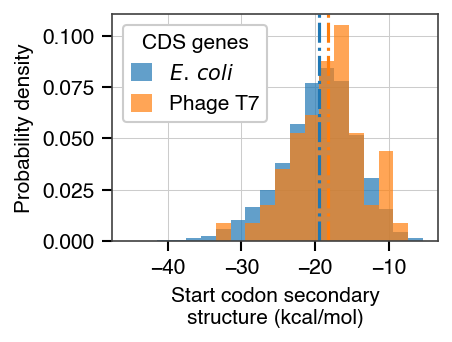

In [13]:
a, b = np.histogram(np.concatenate((temp_df[col_name].values, virus_df[col_name].values)), 20)
fig, ax = plt.subplots(figsize=(2.8,2))
ax.hist(temp_df[col_name], bins=b, label='$E.\, coli$', density=True, alpha=0.7)
ax.hist(virus_df[col_name], bins=b, label='Phage T7', density=True, alpha=0.7)
ax.axvline(temp_df[col_name].mean(), color=colors[0], linestyle='-.')
ax.axvline(virus_df[col_name].mean(), color=colors[1], linestyle='-.')
ax.set_xlabel(col_to_label_dict[col_name])
ax.set_ylabel('Probability density')
plt.legend(title='CDS genes', framealpha=1.0, handlelength=1, handleheight=1)
plt.savefig(figs_dir + '/Ecoli_T7_{}.png'.format(col_name), dpi=300, bbox_inches='tight')

# Extended analysis to many *E. coli* viruses

Compare each virus separately to all *E. coli* genes

In [19]:
# col_name = 'aSD_binding'
col_name = 'sec_struct'
# col_name = 'SD_accessibility'
# col_name = 'GC_cds'
# col_name = 'iCUB'

temp_df = combined_df
host_mean = temp_df[col_name].mean()
###For the violin plot at the top
mean_virus = []
p_vals = []
for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    virus_df['SD_accessibility'] = virus_df['sec_struct'] - virus_df['sec_struct_bound']
    mean_virus.append(virus_df[col_name].mean())
    t, p = stats.ttest_ind(temp_df[col_name], virus_df[col_name], equal_var=False)
    p_vals.append(p)
#     concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
#     concat_df['binary_predictor'] = 1
#     concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
#     fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
#     p_vals.append(fitted.pvalues[1])
truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)
#
#
#
zippy = list(zip(p_vals, mean_virus))
lside = len([1 for i,j in zippy if i < 0.01 and j < host_mean])
rside = len([1 for i,j in zippy if i < 0.01 and j >= host_mean])
print('N significant no FDR (total={}):'.format(len(p_vals)), lside, rside)
#
zippy = list(zip(correct_p_vals, mean_virus))
lside = len([1 for i,j in zippy if i < 0.01 and j < host_mean])
rside = len([1 for i,j in zippy if i < 0.01 and j >= host_mean])
print('N significant w/ FDR(total={}):'.format(len(p_vals)), lside, rside)
#
zippy = list(zip(correct_p_vals, mean_virus))
lside = len([1 for i,j in zippy if j < host_mean])
rside = len([1 for i,j in zippy if j >= host_mean])
print('N on either side regardless of significance(total={}):'.format(len(p_vals)), lside, rside)
print('Host value: {}, and mean of viruses: {}'.format(host_mean, np.mean(mean_virus)))

N significant no FDR (total=373): 133 34
N significant w/ FDR(total=373): 94 31
N on either side regardless of significance(total=373): 302 71
Host value: -19.479728585657366, and mean of viruses: -20.65027941162932


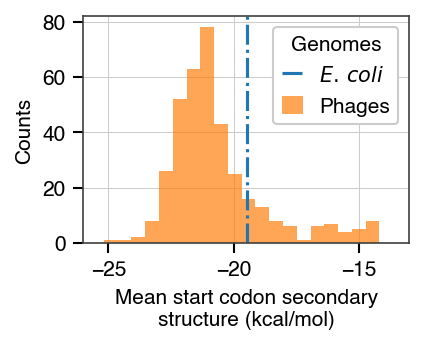

In [20]:
fig, ax = plt.subplots(figsize=(2.8, 2))
ax.hist(mean_virus, 20, color=colors[1], label='Phages', alpha=0.7)
ax.axvline(temp_df[col_name].mean(), color=colors[0], linestyle='-.', label='$E.\, coli$')
ax.set_ylabel('Counts')
ax.set_xlabel(mean_col_to_label_dict[col_name])
plt.legend(title='Genomes', framealpha=1.0, handlelength=1, handleheight=1)
if col_name == 'aSD_binding':
    ax.set_xlim(-7.99, -3.1)
elif col_name == 'sec_struct':
    ax.set_xlim(-26, -13) 
plt.savefig(figs_dir + '/Ecoli_allphage_{}.png'.format(col_name), dpi=300, bbox_inches='tight')

**Comparing against different categories of *E. coli* genes**

In [24]:
# col_name = 'aSD_binding'
col_name = 'sec_struct'
# col_name = 'SD_accessibility'

###For the violin plot at the top
mean_virus = []
for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    virus_df['SD_accessibility'] = virus_df['sec_struct'] - virus_df['sec_struct_bound']
    mean_virus.append(virus_df[col_name].mean())
    
###For all the host information    
host_df_list = []
host_df_list.append(combined_df)
percentiles_to_test = [25, 50, 75, 90, 95]
for i in percentiles_to_test:
    temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
    percentile_thresh = np.percentile(temp_df['prot_abundance'], i)
    host_df_list.append(temp_df[temp_df['prot_abundance']>=percentile_thresh])
host_df_list.append(combined_df[(combined_df['essentiality']=='Essential')])
host_df_list.append(combined_df[(combined_df['essentiality']=='Non-essential')])
#
host_means = [temp_df[col_name].mean() for temp_df in host_df_list]
host_errs = [temp_df[col_name].std()/np.sqrt(temp_df.shape[0]) for temp_df in host_df_list]

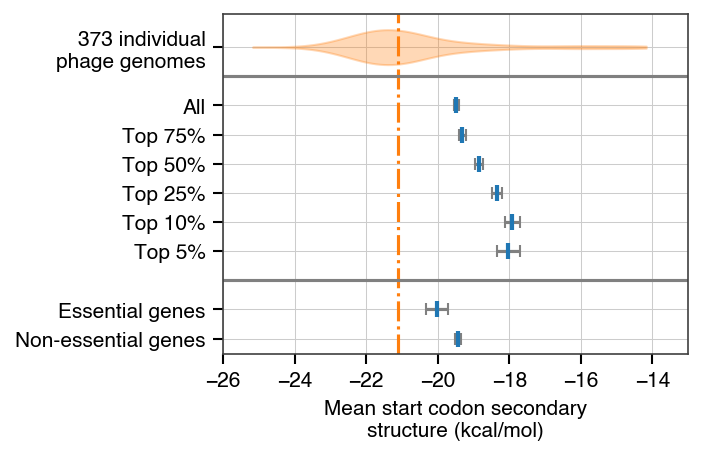

In [25]:
###Plotting
all_y_vals = list(np.arange(0, -(len(percentiles_to_test)+1)/2, -0.5))
highest = all_y_vals[-1]
all_y_vals = all_y_vals + list(np.arange(highest-1.0, highest-2.0, -0.5))

fig, ax = plt.subplots(figsize=(4,3))
vparts = ax.violinplot([mean_virus], widths=0.6, vert=False, showextrema=False, points=100)
for pc in vparts['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor(colors[1])
ax.axvline(np.median(mean_virus), c=colors[1], linestyle='-.')
ax.axhline(0.5, c='gray')
#Plotting two here to hack the line/dot overlaps
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='|', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=2, markersize=8, mew=2)
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=1, capsize=3, capthick=1, elinewidth=1)
#
ax.axhline(-3, c='gray')
ax.set_xlabel(mean_col_to_label_dict[col_name])
ax.set_yticks([1]+all_y_vals)
ax.set_yticklabels(['373 individual\nphage genomes',\
                    'All',\
                    'Top 75%',\
                    'Top 50%',\
                    'Top 25%',\
                    'Top 10%',\
                    'Top 5%',\
                    'Essential genes',\
                    'Non-essential genes']);
if col_name == 'aSD_binding':
    ax.set_xlim(-7.99, -3.1)
elif col_name == 'sec_struct':
    ax.set_xlim(-26, -13) 
plt.savefig(figs_dir + '/Ecoli_{}_categories.png'.format(col_name), dpi=300, bbox_inches='tight')

**And getting statistics for all those comparisons**

Currently takes a little time to run this but... meh?

In [ ]:
assert len(list(combined_df['genome_id'].value_counts().keys())) == 1
host_name = combined_df['genome_id'].value_counts().keys()[0]
#
results = []
for temp_df in host_df_list:
    beta_vals = []
    p_vals = []
    for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
        virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
        virus_df['SD_accessibility'] = virus_df['sec_struct'] - virus_df['sec_struct_bound']
        ###Welch's T-test, not assuming equal variance
        t, p = stats.ttest_ind(temp_df[col_name], virus_df[col_name], equal_var=False)
        p_vals.append(p)
        ###Logistic regression to get the directionality of the difference
        concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
        concat_df['binary_predictor'] = 1
        concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
        fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
        beta_vals.append(fitted.params[1])
    truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)
    zippy = list(zip(correct_p_vals, beta_vals))
    lside = len([1 for i,j in zippy if i < 0.01 and j < 0])
    rside = len([1 for i,j in zippy if i < 0.01 and j >= 0])
    results.append((lside, rside))

In [ ]:
fig, ax = plt.subplots(figsize=(2.15,2.45))
l_bar = ax.barh(all_y_vals, [-1*i[0] for i in results], height=0.4,\
             color='gray')
r_bar = ax.barh(all_y_vals, [i[1] for i in results], height=0.4,\
            color='gray')
ax.set_yticklabels('')
ax.set_xticks([-300, -150, 0, 150, 300])
ax.set_xticklabels([300, 150, 0, 150, 300])
ax.set_xlim(-330, 330)
ax.axvline(0, c='k')
ax.set_yticks(all_y_vals[::-1])
ax.set_ylim(-4.25, 0.5)
ax.axhline(-3, c='gray')


ax.set_xlabel('Number of phage genomes\nwith significant differences')
plt.savefig(figs_dir + '/Ecoli_{}_categories_bar.png'.format(col_name), dpi=300, bbox_inches='tight')

# Multi-variate analysis

In [26]:
from scipy.stats.mstats import zscore

In [36]:
assert len(list(combined_df['genome_id'].value_counts().keys())) == 1
host_name = combined_df['genome_id'].value_counts().keys()[0]
temp_df = combined_df
comparison_vals_a = []
comparison_vals_b = []
p_vals_a = []
p_vals_b = []

for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
#     if '7841' not in virus_tsv:
#         continue
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    #
    concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0
    fitted = smf.logit('binary_predictor ~ zscore(aSD_binding) + zscore(sec_struct)', data=concat_df).fit(disp=0)    
#     fitted = smf.logit('binary_predictor ~ zscore(aSD_binding) + zscore(sec_struct) + zscore(GC_cds) + zscore(iCUB)', data=concat_df).fit(disp=0)

    comparison_vals_a.append(fitted.params[1])
    comparison_vals_b.append(fitted.params[2])

    p_vals_a.append(fitted.pvalues[1])
    p_vals_b.append(fitted.pvalues[2])

In [37]:
truth_array, correct_p_vals_a = multi.fdrcorrection(p_vals_a, alpha=0.01)
print(np.sum(truth_array))
truth_array, correct_p_vals_b = multi.fdrcorrection(p_vals_b, alpha=0.01)
print(np.sum(truth_array))


truth_array_a, correct_p_vals_a = multi.fdrcorrection(p_vals_a, alpha=0.01)
truth_array_b, correct_p_vals_b = multi.fdrcorrection(p_vals_b, alpha=0.01)
truth_array = []
for i,j,k,l in zip(truth_array_a, truth_array_b, comparison_vals_a, comparison_vals_b):
    if i == 1:
        if k < 0 and l > 0:
            truth_array.append(1)
print(np.sum(truth_array))

52
151
27


Text(0, 0.5, 'Effect size\n(Start codon secondary structure)')

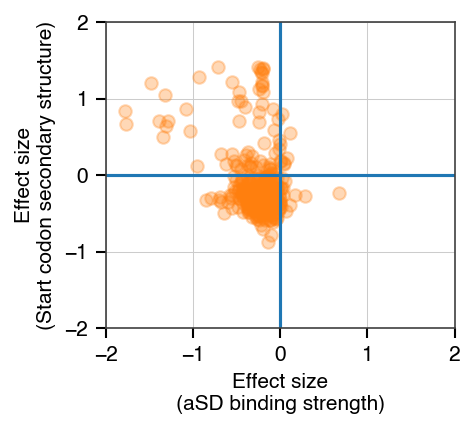

In [38]:
fig, ax = plt.subplots(figsize=(3,2.7))
ax.plot(comparison_vals_a, comparison_vals_b, marker='o', linestyle='', c=colors[1], alpha=0.3)
ax.axvline(0, c=colors[0])
ax.axhline(0, c=colors[0])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('Effect size\n(aSD binding strength)')
ax.set_ylabel('Effect size\n(Start codon secondary structure)')
# plt.savefig(figs_dir + '/Ecoli_multivariate_scatter.png'.format(col_name), dpi=300, bbox_inches='tight')
# plt.savefig(figs_dir + '/Ecoli_multivariate_scatter_withcovariates.png'.format(col_name), dpi=300, bbox_inches='tight')

# Getting independent sets and lifestyle values

In [39]:
lifestyle_df = pd.read_csv('../Data/MVP_data/lifestyle_results_BACPHLIP.tsv', sep='\t', index_col=2)
lifestyle_df = lifestyle_df.drop('Unnamed: 0', axis=1)
lifestyle_df = lifestyle_df[lifestyle_df['host_id']==int(562)]
print(lifestyle_df.shape)
lifestyle_df.head()

(374, 3)


,host_id,phage_lifestyle,lifestyle_probability_difference
phage_id,,,
2503,562,Temperate,0.775
6630,562,Temperate,0.850
11767,562,Temperate,1.000
5497,562,Virulent,0.625
5096,562,Virulent,1.000


In [40]:
independent_set = []
with open('../Data/MVP_data/host_linked_genomes/562_independent.txt', 'r') as infile:
    for line in infile:
        independent_set.append(line.strip())
print(independent_set[:5])

['146', '170', '177', '179', '188']


# Re-doing analyses to assess robustness

In [54]:
analyze_independent_only = True
split_according_to_lifestyle = True

In [55]:
assert len(list(combined_df['genome_id'].value_counts().keys())) == 1
host_name = combined_df['genome_id'].value_counts().keys()[0]
temp_df = combined_df
comparison_vals_a = []
comparison_vals_b = []
p_vals_a = []
p_vals_b = []
lifestyle_vals = []

for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    if analyze_independent_only:
        if vir_name not in independent_set:
            continue
    if split_according_to_lifestyle:
        ind_lifestyle = lifestyle_df.loc[int(vir_name)]['phage_lifestyle']
        ind_lifestyle_prob = lifestyle_df.loc[int(vir_name)]['lifestyle_probability_difference']
        if ind_lifestyle_prob < 0.95:
            continue
        lifestyle_vals.append(ind_lifestyle)    
    
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    #
    concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0
    fitted = smf.logit('binary_predictor ~ zscore(aSD_binding) + zscore(sec_struct)', data=concat_df).fit(disp=0)    
#     fitted = smf.logit('binary_predictor ~ zscore(aSD_binding) + zscore(sec_struct) + zscore(GC_cds) + zscore(iCUB)', data=concat_df).fit(disp=0)

    comparison_vals_a.append(fitted.params[1])
    comparison_vals_b.append(fitted.params[2])

    p_vals_a.append(fitted.pvalues[1])
    p_vals_b.append(fitted.pvalues[2])

In [56]:
quick_df = pd.DataFrame(
    {'aSD_binding': comparison_vals_a,
     'sec_struct': comparison_vals_b,
     'lifestyle': lifestyle_vals
    })
print(quick_df.shape)

(102, 3)


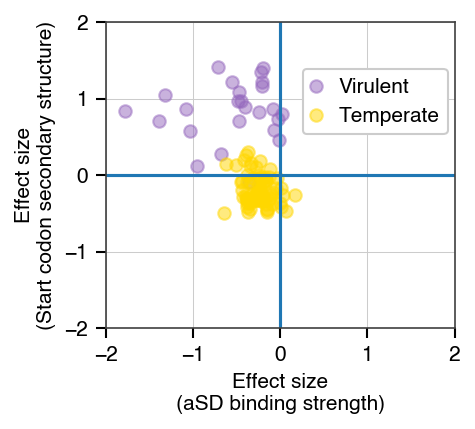

In [57]:
fig, ax = plt.subplots(figsize=(3,2.7))
ax.plot(quick_df[quick_df['lifestyle']=='Virulent']['aSD_binding'],
        quick_df[quick_df['lifestyle']=='Virulent']['sec_struct'], 
        marker='o', linestyle='', c=colors[4], alpha=0.5,
        label='Virulent')
ax.plot(quick_df[quick_df['lifestyle']=='Temperate']['aSD_binding'],
        quick_df[quick_df['lifestyle']=='Temperate']['sec_struct'], 
        marker='o', linestyle='', c='gold', alpha=0.5,
        label='Temperate')
ax.axvline(0, c=colors[0])
ax.axhline(0, c=colors[0])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('Effect size\n(aSD binding strength)')
ax.set_ylabel('Effect size\n(Start codon secondary structure)')
leg = plt.legend(loc=1, framealpha=1.0, handlelength=0.5, handleheight=0.5)
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
bb.y1 -=0.12
bb.x1 += 0.01
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
plt.savefig(figs_dir + '/Ecoli_multivariate_scatter_lifestyle.png'.format(col_name), dpi=300, bbox_inches='tight')
# plt.savefig(figs_dir + '/Ecoli_multivariate_scatter_withcovariates_lifestyle.png'.format(col_name), dpi=300, bbox_inches='tight')

# Re-doing violin plot figs with strict independent set

In [66]:
# col_name = 'sec_struct'
col_name = 'aSD_binding'
###For the violin plot at the top
mean_virus = []
for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
    if virus_tsv.split('/')[-1].split('.clean.tsv')[0] not in independent_set:
        continue
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    mean_virus.append(virus_df[col_name].mean())
    
###For all the host information    
host_df_list = []
host_df_list.append(combined_df)
percentiles_to_test = [25, 50, 75, 90, 95]
for i in percentiles_to_test:
    temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
    percentile_thresh = np.percentile(temp_df['prot_abundance'], i)
    host_df_list.append(temp_df[temp_df['prot_abundance']>=percentile_thresh])
host_df_list.append(combined_df[(combined_df['essentiality']=='Essential')])
host_df_list.append(combined_df[(combined_df['essentiality']=='Non-essential')])
#
host_means = [temp_df[col_name].mean() for temp_df in host_df_list]
host_errs = [temp_df[col_name].std()/np.sqrt(temp_df.shape[0]) for temp_df in host_df_list]

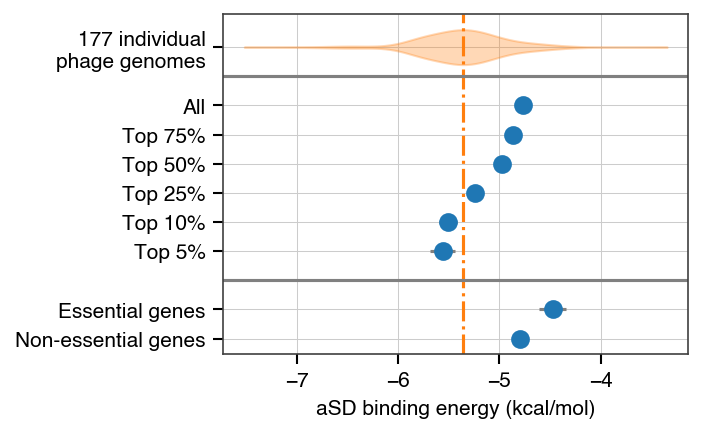

In [67]:
###Plotting
all_y_vals = list(np.arange(0, -(len(percentiles_to_test)+1)/2, -0.5))
highest = all_y_vals[-1]
all_y_vals = all_y_vals + list(np.arange(highest-1.0, highest-2.0, -0.5))

fig, ax = plt.subplots(figsize=(4,3))
vparts = ax.violinplot([mean_virus], widths=0.6, vert=False, showextrema=False, points=100)
for pc in vparts['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor(colors[1])
ax.axvline(np.median(mean_virus), c=colors[1], linestyle='-.')
ax.axhline(0.5, c='gray')
#
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='o', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=1, markersize=8)
ax.axhline(-3, c='gray')
ax.set_xlabel(col_to_label_dict[col_name])
ax.set_yticks([1]+all_y_vals)
ax.set_yticklabels(['{} individual\nphage genomes'.format(len(mean_virus)),\
                    'All',\
                    'Top 75%',\
                    'Top 50%',\
                    'Top 25%',\
                    'Top 10%',\
                    'Top 5%',\
                    'Essential genes',\
                    'Non-essential genes']);
# plt.savefig(figs_dir + '/Ecoli_{}_categories.png'.format(col_name), dpi=300, bbox_inches='tight')

In [68]:
results = []
for temp_df in host_df_list:
    beta_vals = []
    p_vals = []
    for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
        if virus_tsv.split('/')[-1].split('.clean.tsv')[0] not in independent_set:
            continue
        virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
        virus_df['SD_accessibility'] = virus_df['sec_struct'] - virus_df['sec_struct_bound']
        ###Welch's T-test, not assuming equal variance
        t, p = stats.ttest_ind(temp_df[col_name], virus_df[col_name], equal_var=False)
        p_vals.append(p)
        ###Logistic regression to get the directionality of the difference
        concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
        concat_df['binary_predictor'] = 1
        concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
        fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
        beta_vals.append(fitted.params[1])
    truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)
    zippy = list(zip(correct_p_vals, beta_vals))
    lside = len([1 for i,j in zippy if i < 0.01 and j < 0])
    rside = len([1 for i,j in zippy if i < 0.01 and j >= 0])
    results.append((lside, rside))

Text(0.5, 0, 'Number of phage genomes\nwith significant differences')

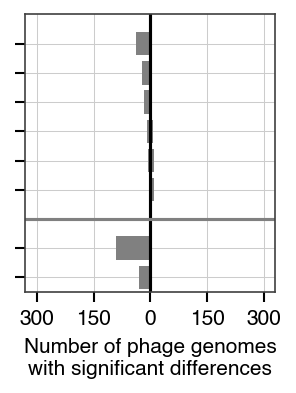

In [69]:
fig, ax = plt.subplots(figsize=(2.15,2.45))
l_bar = ax.barh(all_y_vals, [-1*i[0] for i in results], height=0.4,\
             color='gray')
r_bar = ax.barh(all_y_vals, [i[1] for i in results], height=0.4,\
            color='gray')
ax.set_yticklabels('')
ax.set_xticks([-300, -150, 0, 150, 300])
ax.set_xticklabels([300, 150, 0, 150, 300])
ax.set_xlim(-330, 330)
ax.axvline(0, c='k')
ax.set_yticks(all_y_vals[::-1])
ax.set_ylim(-4.25, 0.5)
ax.axhline(-3, c='gray')


ax.set_xlabel('Number of phage genomes\nwith significant differences')
# plt.savefig(figs_dir + '/Ecoli_{}_categories_bar.png'.format(col_name), dpi=300, bbox_inches='tight')

In [71]:
[-1*i[0] for i in results]

[-38, -23, -17, -9, -5, -3, -90, -30]

In [72]:
[i[1] for i in results]

[1, 1, 3, 6, 9, 9, 0, 1]